In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Apr 28 04:04:37 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install pytorch-lightning


     |████████████████████████████████| 582 kB 8.6 MB/s 
     |████████████████████████████████| 136 kB 52.2 MB/s 
     |████████████████████████████████| 408 kB 50.6 MB/s 
     |████████████████████████████████| 596 kB 37.9 MB/s 
     |████████████████████████████████| 1.1 MB 35.0 MB/s 
     |████████████████████████████████| 271 kB 24.4 MB/s 
     |████████████████████████████████| 144 kB 37.1 MB/s 
     |████████████████████████████████| 94 kB 1.7 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [3]:
!pip install einops

In [4]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from multiprocessing import cpu_count
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics.functional import accuracy
from sklearn.metrics import classification_report, confusion_matrix
from torch.nn.utils.rnn import pad_sequence
import glob
import os
from google.colab import drive

drive.mount('/content/drive')

# Commented out IPython magic to ensure Python compatibility.
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
from transformer import ViT

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

MY_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(MY_PALETTE))

#rcParams['figure.figsize'] = 16, 10

pl.seed_everything(42)

# X_train = pd.read_csv(r"C:\Users\Husain's PC\Dissertation\LSTM\X_train.csv")
# y_train = pd.read_csv(r"C:\Users\Husain's PC\Dissertation\LSTM\y_train.csv")

data_path = r"/content/drive/MyDrive/Dissertation/inertial_aligned"

def load_data(path, train_indexes=[5,6,7,8,9,10,11,12,13,14,15,16]):
    data_paths = list(glob.glob(os.path.join(path, "*")))

    train_data = []
    train_label = []
    test_data = []
    test_label = []
    for i, class_path in enumerate(data_paths):
        file_paths = list(glob.glob(os.path.join(class_path, "*.csv")))
        for fl_path in file_paths:
            if int(fl_path.split('\\')[-1].split("_s")[-1].split(".csv")[0]) in train_indexes:
                temp_df = pd.read_csv(fl_path)
                train_data.append(temp_df)
                train_label.append(i)
            else:
                temp_df = pd.read_csv(fl_path)
                test_data.append(temp_df)
                test_label.append(i)

    return train_data, train_label, test_data, test_label


x_train, y_train, x_test, y_test = load_data(data_path)


def split_in_windows(data, labels, win_length=200, no_win=150, overlap=10):
    data_win = []
    for idx in range(0, len(data)):
        # sliding window
        # sequence_features_windows = [data[idx].values[i:i + win_length] for i in
        #                              range(0, len(data[idx].values - win_length), overlap) if i + win_length < len(data[idx].values)]
        # tokens
        output = np.array(
            [np.array(data[idx].values[i:i + win_length, :]) for i in range(0, len(data[idx].values) - win_length, int((len(data[idx].values) - win_length) / no_win))
             if len(data[idx].values) - i > win_length])
        output = output[:no_win]

        data_win.append((output, labels[idx]))

        # for window in sequence_features_windows:
        #     window_df = pd.DataFrame(window)
        #     data_win.append((window_df, labels[idx]))

    return data_win

data_train_win = split_in_windows(x_train, y_train)
data_test_win = split_in_windows(x_test, y_test)

#X_train.head()

#y_train.head()

#y_train.activity.value_counts().plot(kind='bar')
#plt.xticks(rotation=45)
#plt.show();

# label_encoder = LabelEncoder()
# encoded_labels = label_encoder.fit_transform(y_train)

#encoded_labels[:5]

#label_encoder.classes_

# y_train["label"] = encoded_labels

#y_train.head()

# FEATURE_COLUMNS = X_train.columns.tolist()[3:]

#FEATURE_COLUMNS

#X_train.series_id.value_counts()

# (X_train.series_id.value_counts() == 128).sum() == len(y_train)

# sequences = []
#
# for series_id, group in X_train.groupby("series_id"):
#     sequence_features = group[FEATURE_COLUMNS]
#     label = y_train[y_train.series_id == series_id].iloc[0].label
#
#     # padding
#     # sequence_features = pd.DataFrame(np.concatenate((sequence_features.values, np.zeros((6000 - len(sequence_features), 12)))))
#
#     # sliding window
#     sequence_features_windows = [sequence_features.values[i:i + 200] for i in range(0, len(sequence_features.values - 200), 10)]
#
#     for window in sequence_features_windows:
#         window_df = pd.DataFrame(window)
#
#         sequences.append((window_df, label))

# 5
#sequences[0]

"""Split into training and testing"""

# train_sequences, test_sequences = train_test_split(sequences, test_size=0.2)

# len(train_sequences), len(test_sequences)

# train_sequences[0][0]



Global seed set to 42


Mounted at /content/drive


'Split into training and testing'

In [5]:

class SurfaceDataset(Dataset):

    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence, label = self.sequences[idx]
        return dict(
            sequence=torch.Tensor(sequence),
            label=torch.tensor(label).long()
        )


class SurfaceDataModule(pl.LightningDataModule):
    def __init__(self, train_sequences, test_sequences, batch_size):
        super().__init__()
        self.train_sequences = train_sequences
        self.test_sequences = test_sequences
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_dataset = SurfaceDataset(self.train_sequences)
        self.test_dataset = SurfaceDataset(self.test_sequences)

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=cpu_count()
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )


N_EPOCHS = 100
BATCH_SIZE = 64

data_module = SurfaceDataModule(data_train_win, data_test_win, BATCH_SIZE)


class SequenceModel(nn.Module):
    def __init__(self, n_features, n_classes, n_hidden=256, n_layers=3):
        super().__init__()

        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=n_hidden,
            num_layers=n_layers,
            batch_first=True,
            dropout=0.9
        )

        self.classifier = nn.Linear(n_hidden, n_classes)

    def forward(self, x):
        self.lstm.flatten_parameters()
        _, (hidden, _) = self.lstm(x)

        out = hidden[-1]
        return self.classifier(out)


class SurfacePredictor(pl.LightningModule):
    def __init__(self, n_features: int, n_classes: int):
        super().__init__()
        # self.model = SequenceModel(n_features, n_classes)
        self.model = ViT(no_tokens=150, token_dim=200, dim=2048, no_feat=12, num_classes=9, heads=5, mlp_dim=512, depth=10, dropout=0.9 )
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x, labels=None):
        output = self.model(x)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions, labels)

        self.log("train_loss", loss, prog_bar=True, logger=True)
        self.log("train_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": step_accuracy}

    def validation_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions, labels)

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.log("val_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": step_accuracy}

    def testing_step(self, batch, batch_idx):
        sequences = batch["sequence"]
        labels = batch["label"]
        loss, outputs = self(sequences, labels)
        predictions = torch.argmax(outputs, dim=1)
        step_accuracy = accuracy(predictions, labels)

        self.log("test_loss", loss, prog_bar=True, logger=True)
        self.log("test_accuracy", step_accuracy, prog_bar=True, logger=True)
        return {"loss": loss, "accuracy": step_accuracy}

    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.0001)


model = SurfacePredictor(
    n_features=12,
    n_classes=9
)

# Commented out IPython magic to ensure Python compatibility.
# %load_ext tensorboard
# %tensorboard --logdir ./lightning_logs

checkpoint_callback = ModelCheckpoint(
    dirpath="checkpints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="activity")


In [6]:
trainer = pl.Trainer(
    logger=logger,
    checkpoint_callback=checkpoint_callback,
    max_epochs=N_EPOCHS,
    progress_bar_refresh_rate=2,
    accelerator='gpu', 
    devices=1
    )


#dummy_input = torch.stack((torch.from_numpy(data_module.train_sequences[0][0]), torch.from_numpy(data_module.train_sequences[0][0]))).float()
#model(dummy_input)


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:152: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fdc44cedb50>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7fdc44cedb50>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:97: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=2)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Tra

In [7]:

trainer.fit(model, data_module)

# trainer.test()

"""# Predictions

Look at predictions, evaluate results
"""

trained_model = SurfacePredictor.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_features=12,
    n_classes=9
)

trained_model.freeze()

test_dataset = SurfaceDataset(data_test_win)

predictions = []
labels = []

for item in tqdm(test_dataset):
    sequence = item["sequence"]
    label = item["label"]

    _, output, = trained_model(sequence.unsqueeze(dim=0))
    prediction = torch.argmax(output, dim=1)
    predictions.append(prediction.item())
    labels.append(label.item())

Missing logger folder: lightning_logs/activity
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | model     | ViT              | 52.6 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
52.6 M    Trainable params
0         Non-trainable params
52.6 M    Total params
210.260   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1931: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

              precision    recall  f1-score   support

     cereals       1.00      1.00      1.00         4
      dishes       1.00      0.50      0.67         4
      laptop       1.00      0.50      0.67         4
   newspaper       0.60      0.75      0.67         4
    sandwich       0.50      0.25      0.33         4
  smartphone       0.50      1.00      0.67         4
       table       1.00      0.75      0.86         4
         tea       0.80      1.00      0.89         4
        tidy       0.60      0.75      0.67         4

    accuracy                           0.72        36
   macro avg       0.78      0.72      0.71        36
weighted avg       0.78      0.72      0.71        36



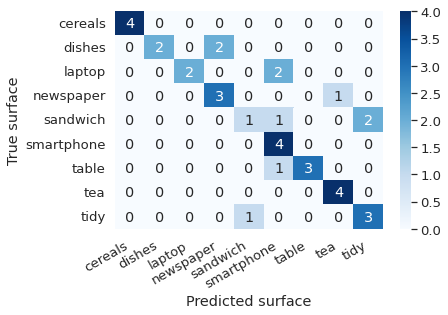

In [8]:


print(
    classification_report(labels, predictions, target_names=['cereals','dishes','laptop','newspaper','sandwich','smartphone','table','tea','tidy'])
)


def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True surface')
    plt.xlabel('Predicted surface')


cm = confusion_matrix(labels, predictions)
df_cm = pd.DataFrame(
    cm, index=['cereals','dishes','laptop','newspaper','sandwich','smartphone','table','tea','tidy'], columns=['cereals','dishes','laptop','newspaper','sandwich','smartphone','table','tea','tidy']
)
df_cm

show_confusion_matrix(df_cm)

